In [1]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding


# Others
import re
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from sklearn.manifold import TSNE

Using TensorFlow backend.


In [2]:
data = pd.read_csv('movie_data.csv', encoding='utf-8')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null int64
dtypes: int64(1), object(1)
memory usage: 781.3+ KB


In [4]:
data.isna().sum()

review       0
sentiment    0
dtype: int64

In [5]:
data = data.dropna()

In [6]:
def clean_text1(text):
    
    ## Remove puncuation
    # pu = set(string.punctuation)
    # text = ''.join(ch for ch in text if ch not in pu)
    text = text.translate(str.maketrans(' ',' ',string.punctuation))
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 2]
    
    text = " ".join(text)

    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    ## Stemming
    text = text.split()
    stemmer = nltk.stem.SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

In [7]:
def clean_text(text):
    
    ## Convert words to lower case and split them
    #text = text.lower().split()
    text = text.lower()
    ## Remove stop words
    #stops = set(stopwords.words("english"))
    #text = [w for w in text if not w in stops and len(w) >= 2]
    
    #text = " ".join(text)
    
    

    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    ## Remove puncuation
    # pu = set(string.punctuation)
    # text = ''.join(ch for ch in text if ch not in pu)
    text = text.translate(str.maketrans(' ',' ',string.punctuation))

    ## Stemming
    text = text.split()
    text = [w for w in text if  len(w) >= 2]
    stemmer = nltk.stem.SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

In [8]:
# apply the above function to df['text']

data['review'] = data['review'].map(lambda x: clean_text(x))

In [9]:
data.head()

,review,sentiment
0,went and saw this movi last night after be coa...,1
1,actor turn director bill paxton follow up his ...,1
2,as recreat golfer with some knowledg of the sp...,1
3,saw this film in sneak preview and it is delig...,1
4,bill paxton has taken the true stori of the 19...,1


In [10]:
data['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [11]:
### Create sequence
vocabulary_size = 5000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(data['review'])

In [12]:
print(len(tokenizer.index_word))

72028


In [13]:
max_lenght = max([len(string.split()) for string in data.review])
print(max_lenght)

2389


In [14]:
avg_length = np.mean([len(string.split()) for string in data.review])
print(avg_length)

226.15302


In [15]:
length_token = [len(string.split()) for string in data.review]

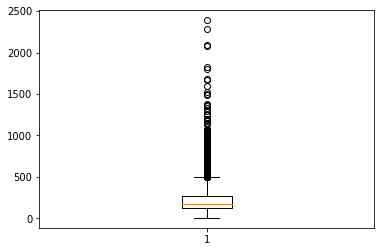

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
_=plt.boxplot(length_token)

In [17]:
sequences = tokenizer.texts_to_sequences(data['review'])

In [18]:
text_data = pad_sequences(sequences, maxlen=500)

In [19]:
## Network architecture

model = Sequential()
model.add(Embedding(5000, 32, input_length=500))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 168,353
Trainable params: 168,353
Non-trainable params: 0
_________________________________________________________________


In [21]:
## Fit the model

history = model.fit(text_data, np.array(data.sentiment), validation_split=0.4, epochs=10).history

Instructions for updating:
Use tf.cast instead.
Train on 30000 samples, validate on 20000 samples
Epoch 1/10
30000/30000 [==============================] - 361s 12ms/step - loss: 0.4903 - acc: 0.7638 - val_loss: 0.4313 - val_acc: 0.8118
Epoch 2/10
30000/30000 [==============================] - 345s 11ms/step - loss: 0.3829 - acc: 0.8379 - val_loss: 0.4342 - val_acc: 0.8103
Epoch 3/10
30000/30000 [==============================] - 338s 11ms/step - loss: 0.3371 - acc: 0.8628 - val_loss: 0.4140 - val_acc: 0.8171
Epoch 4/10
30000/30000 [==============================] - 355s 12ms/step - loss: 0.3213 - acc: 0.8714 - val_loss: 0.3881 - val_acc: 0.8377
Epoch 5/10
30000/30000 [==============================] - 357s 12ms/step - loss: 0.2910 - acc: 0.8840 - val_loss: 0.4492 - val_acc: 0.7899
Epoch 6/10
30000/30000 [==============================] - 352s 12ms/step - loss: 0.2865 - acc: 0.8857 - val_loss: 0.4127 - val_acc: 0.8413
Epoch 7/10
30000/30000 [==============================] - 362s 12ms/

In [29]:
#Save the model
import pickle
model.save('save_models/word_embedding_self2.h5')
pickle.dump(history, open("history.p", "wb"))

In [30]:
#And load it back, just to make sure it works:
model = load_model('save_models/word_embedding_self2.h5')
history = pickle.load(open("history.p", "rb"))

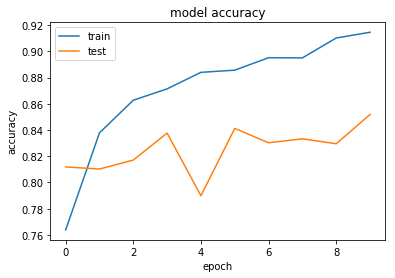

In [31]:
# Evaluation
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
_=plt.legend(['train', 'test'], loc='upper left')

In [32]:
#Let us test some  samples
test_sample_1 = "This movie is fantastic! I really like it because it is so good!"
test_sample_2 = "Good movie!"
test_sample_3 = "Maybe I like this movie."
test_sample_4 = "Not to my taste, will skip and watch another movie"
test_sample_5 = "if you like action, then this movie might be good for you."
test_sample_6 = "Bad movie!"
test_sample_7 = "Not a good movie!"
test_sample_8 = "This movie really sucks! Can I get my money back please?"
test_sample_9 = "i didn't like the movie"
test_samples = [test_sample_1, test_sample_2, test_sample_3, test_sample_4, test_sample_5, test_sample_6, test_sample_7, test_sample_8, test_sample_9]

In [33]:
test_samples_processed = [clean_text(x) for x in test_samples]
test_samples_processed

['this movi is fantast realli like it becaus it is so good',
 'good movi',
 'mayb like this movi',
 'not to my tast will skip and watch anoth movi',
 'if you like action then this movi might be good for you',
 'bad movi',
 'not good movi',
 'this movi realli suck can get my money back pleas',
 'did not like the movi']

In [34]:
sample_tok = tokenizer.texts_to_sequences(test_samples_processed)

In [35]:
sample_pad = pad_sequences(sample_tok, maxlen=500)

In [36]:
model.predict(x=sample_pad)

array([[0.9495424 ],
       [0.6151085 ],
       [0.35789555],
       [0.05614614],
       [0.70110023],
       [0.16361806],
       [0.53374237],
       [0.0532155 ],
       [0.47596258]], dtype=float32)

In [37]:
result = np.concatenate((np.array(test_samples_processed).reshape(9,1), model.predict(x=sample_pad)), axis=1)

In [38]:
def fun1(row):
    if row > 0.5:
        return 'Liked'
    else:
        return 'Not-liked'

In [39]:
result_df = pd.DataFrame(result, columns=['text', 'predict'])
result_df['predict'] = pd.to_numeric(result_df['predict'])
result_df['sentiment'] = result_df['predict'].map(lambda x: fun1(x))
result_df

,text,predict,sentiment
0,this movi is fantast realli like it becaus it ...,0.949542,Liked
1,good movi,0.615109,Liked
2,mayb like this movi,0.357896,Not-liked
3,not to my tast will skip and watch anoth movi,0.056146,Not-liked
4,if you like action then this movi might be goo...,0.701100,Liked
5,bad movi,0.163618,Not-liked
6,not good movi,0.533742,Liked
7,this movi realli suck can get my money back pleas,0.053216,Not-liked
8,did not like the movi,0.475963,Not-liked
